In [158]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import seaborn as sns
from matplotlib.gridspec import GridSpec
import scanpy as sc
import muon as mu
import graphtools
import magic
from matplotlib.pyplot import rc_context
from matplotlib import gridspec
import os


from datashader.mpl_ext import dsshow
import datashader as ds

import matplotlib.colors
cmap = plt.cm.hsv
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist = cmaplist[0:round(len(cmaplist)*0.7)]
cmaplist.reverse()
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('', cmaplist, cmap.N)

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

import sys
sys.path.append('../../../Code/')
from utils import read_dataset_log


In [159]:
figdir = '../../../Figures/Components'

In [160]:
harmony_vars =  ['lane', 'donor']

In [161]:
params = read_dataset_log('Current Dataset Paths')
params.index = params['dataset']
params

,dataset,usage_fn,gene_scores_fn,gene_tpm_fn,tcat_fn,manual_gating_fn,metadata_fn,Processing notebook path,cNMF notebook path,cluster_col,name,cnmf_dir,k,dt,processed_forcnmf_fn,raw_counts_fn
dataset,,,,,,,,,,,,,,,,
AMP-RA,AMP-RA,/data/srlab1/mcurtis/GSK/tcell_proliferation/A...,/data/srlab1/mcurtis/GSK/tcell_proliferation/A...,/data/srlab1/mcurtis/GSK/tcell_proliferation/A...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage_2023070...,NaN,/data/srlab1/mcurtis/GSK/tcell_proliferation/A...,/data/srlab1/mcurtis/GSK/tcell_proliferation/n...,/data/srlab1/mcurtis/GSK/tcell_proliferation/n...,cluster_name,amp_HarmonyRNA,/data/srlab1/mcurtis/GSK/tcell_proliferation/A...,35.0,0_2,/data/srlab1/mcurtis/GSK/tcell_proliferation/A...,/data/srlab1/mcurtis/GSK/tcell_proliferation/A...
Pan-Cancer,Pan-Cancer,/data/srlab1/mcurtis/GSK/tcell_proliferation/z...,/data/srlab1/mcurtis/GSK/tcell_proliferation/z...,/data/srlab1/mcurtis/GSK/tcell_proliferation/z...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage_2023070...,NaN,/data/srlab1/mcurtis/GSK/tcell_proliferation/z...,/data/srlab1/mcurtis/GSK/tcell_proliferation/n...,/data/srlab1/mcurtis/GSK/tcell_proliferation/n...,meta.cluster,PanCancer_HarmonyRNA.20kgenes10X,/data/srlab1/mcurtis/GSK/tcell_proliferation/z...,38.0,0_15,/data/srlab1/mcurtis/GSK/tcell_proliferation/z...,/data/srlab1/mcurtis/GSK/tcell_proliferation/z...
TBRU,TBRU,/data/srlab1/mcurtis/GSK/tcell_proliferation/T...,/data/srlab1/mcurtis/GSK/tcell_proliferation/T...,/data/srlab1/mcurtis/GSK/tcell_proliferation/T...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage_2023070...,NaN,/data/srlab1/mcurtis/GSK/tcell_proliferation/T...,/data/srlab1/mcurtis/GSK/tcell_proliferation/n...,/data/srlab1/mcurtis/GSK/tcell_proliferation/n...,cluster_name,TBRU_HarmonyRNA,/data/srlab1/mcurtis/GSK/tcell_proliferation/T...,35.0,0_2,/data/srlab1/mcurtis/GSK/tcell_proliferation/T...,/data/srlab1/mcurtis/GSK/tcell_proliferation/T...
HIV-Vaccine,HIV-Vaccine,/data/srlab1/dk718/Tcell_cNMF_Comparison/Data/...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Data/...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Data/...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage_2023070...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Manu...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Data/...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Analy...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Analy...,celltype.l2,T_learnHarmonyRNA_RefitBoth_20221022,/data/srlab1/dk718/Tcell_cNMF_Comparison/Data/...,35.0,0_2,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...
UK-Covid,UK-Covid,/data/srlab1/mcurtis/GSK/tcell_proliferation/C...,/data/srlab1/mcurtis/GSK/tcell_proliferation/C...,/data/srlab1/mcurtis/GSK/tcell_proliferation/C...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage_2023070...,NaN,/data/srlab1/dk718/COVID_PBMC/Data/Haniffa/han...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Analy...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Analy...,full_clustering,Haniffa_T_Script_learnHarmonyRNA_RefitBoth,/data/srlab1/mcurtis/GSK/tcell_proliferation/C...,40.0,0_2,/data/srlab1/dk718/COVID_PBMC/Data/Haniffa/han...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...
COMBAT,COMBAT,/data/srlab1/mcurtis/GSK/tcell_proliferation/C...,/data/srlab1/mcurtis/GSK/tcell_proliferation/C...,/data/srlab1/mcurtis/GSK/tcell_proliferation/C...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage_2023070...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/Manua...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Data/...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Analy...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Analy...,Annotation_minor_subset,T_Script_learnHarmonyRNA_RefitBoth,/data/srlab1/mcurtis/GSK/tcell_proliferation/C...,44.0,0_2,/data/srlab1/dk718/Tcell_cNMF_Comparison/Data/...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...
Pan-Tissue,Pan-Tissue,/data/srlab1/dk718/Tcell_cNMF_Comparison/Data/...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Data/...,/data/srlab1/dk718/Tcell_cNMF_Comparison/Data/...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage_2023070...,NaN,/data/srlab1/dk

## Prepare markers

In [165]:
raw_counts_fn = params.loc['HIV-Vaccine', 'raw_counts_fn']
raw_counts_fn

'/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoetal_pbmc_multimodal.merged.T.raw.ADTfixed.h5ad'

In [13]:
outdir = '../../../Data/PerDataset/HaoEtAl'

In [14]:
adata = sc.read(raw_counts_fn)
# adata.obs['frac_ADT'] = adata.obs['nCount_ADT'] / (adata.obs['nCount_ADT'] + adata.obs['nCount_RNA'])
ind = adata.var['feature_types']=='Antibody Capture'

Only considering the two last: ['.ADTfixed', '.h5ad'].
Only considering the two last: ['.ADTfixed', '.h5ad'].


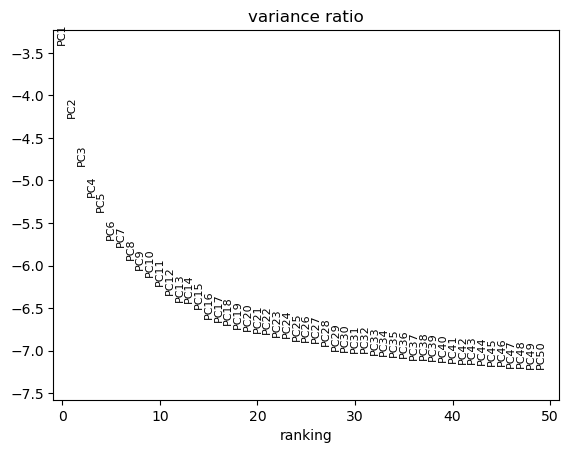

In [15]:
adata_RNA = adata[:,~ind].copy()
sc.pp.highly_variable_genes(adata_RNA, flavor='seurat_v3', n_top_genes=2000)
sc.pp.normalize_per_cell(adata_RNA, counts_per_cell_after=1e4)
sc.pp.log1p(adata_RNA)
sc.pp.scale(adata_RNA, zero_center=False)
sc.tl.pca(adata_RNA, use_highly_variable=True, zero_center=True)
sc.pl.pca_variance_ratio(adata_RNA, log=True, n_pcs=50)

In [16]:
sc.external.pp.harmony_integrate(adata_RNA,  harmony_vars, max_iter_harmony = 30)


2023-08-31 19:03:18,530 - harmonypy - INFO - Iteration 1 of 30
2023-08-31 19:03:50,515 - harmonypy - INFO - Iteration 2 of 30
2023-08-31 19:04:23,526 - harmonypy - INFO - Iteration 3 of 30
2023-08-31 19:04:56,622 - harmonypy - INFO - Iteration 4 of 30
2023-08-31 19:05:29,194 - harmonypy - INFO - Converged after 4 iterations


In [17]:
sc.pp.neighbors(adata_RNA, n_neighbors=5, n_pcs=29, use_rep='X_pca_harmony')

In [18]:
outfn = os.path.join(outdir, 'RNA_logTP1K_ForMAGIC.h5ad')
print(outfn)

../../../Data/PerDataset/HaoEtAl/RNA_logTP1K_ForMAGIC.h5ad


In [19]:
adata_RNA.write(outfn)

Neighbors function kills kernel. Return to whatever this environment issue is later if necessary.

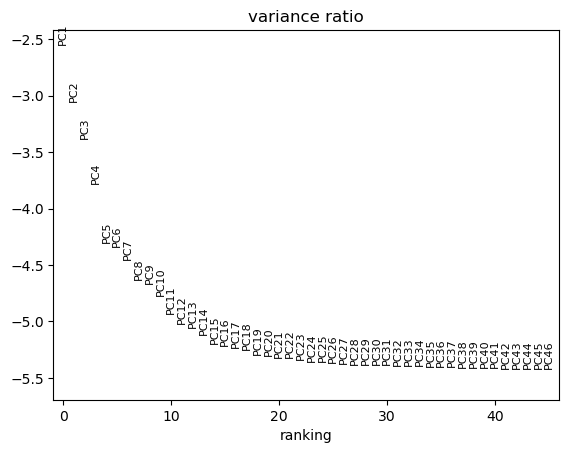

In [20]:
adata_ADT = adata[:,ind].copy()
sc.pp.normalize_per_cell(adata_ADT, counts_per_cell_after=1e4)
Z = adata_ADT.X.todense()
Z[Z==0] = np.nan
gmean = np.exp(np.nansum(np.log(Z+1), axis=1) / Z.shape[1])
Z = np.log((Z / gmean) + 1)
Z[np.isnan(Z)]=0
adata_ADT.X = np.array(Z)

sc.pp.scale(adata_ADT, zero_center=False, max_value=15)

sc.tl.pca(adata_ADT, zero_center=True)
sc.pl.pca_variance_ratio(adata_ADT, log=True, n_pcs=45)

In [21]:
sc.external.pp.harmony_integrate(adata_ADT,  harmony_vars, max_iter_harmony = 30)

2023-08-31 19:06:31,323 - harmonypy - INFO - Iteration 1 of 30
2023-08-31 19:07:03,297 - harmonypy - INFO - Iteration 2 of 30
2023-08-31 19:07:35,058 - harmonypy - INFO - Converged after 2 iterations


In [22]:
sc.pp.neighbors(adata_ADT, n_neighbors=5, n_pcs=19, use_rep='X_pca_harmony')

In [23]:
outfn = os.path.join(outdir, 'ADT_TP10KCLR_ForMAGIC.h5ad')
print(outfn)

../../../Data/PerDataset/HaoEtAl/ADT_TP10KCLR_ForMAGIC.h5ad


In [24]:
adata_ADT.write(outfn)

In [25]:
rna_markers = ['TRAC', 'TRGC1', 'TRDC', 'TRBC1', 'IL2RA', 'FOXP3', 'SELL', 'CCR7', 'KLRB1', 'RTKN2', 'IL7R', 'PASK', 'GATA3',
               'CCR4', 'STAT1', 'IRF4', 'TBX21', 'IFNG', 'CCR5', 'CXCR3', 'CCR6', 'RORA', 'CCL20', 'IL4R', 'STAT4',  'STAT6',  'RORC', 'CCR1', 'IL10']

In [26]:
set(rna_markers) - set(adata_RNA.var.index)

set()

In [27]:
adt_markers = ['AB_CD3-1', 'AB_CD4-2',
               'AB_CD8', 'AB_CD45RA', 'AB_CD45RO',  'AB_CD18', 'AB_CD161',  'AB_CD195', 
               'AB_CD25', 'AB_CD127', 
               'AB_CD27-1',
               'AB_TCR-Vd2', 'AB_TCR-V-7.2', 'AB_TCR-V-9', 'AB_abTCR', 'AB_gdTCR',
               'AB_CD31', 'AB_CD62L', 'AB_CCR7',
               'AB_CD314',
               'AB_CD38-1', 'AB_CD39',
              'AB_CD94', 'AB_CD49b', 'AB_CD28'] 

In [28]:
sorted(adata_ADT.var.index)

['AB_B7-H4',
 'AB_C5L2',
 'AB_CCR10',
 'AB_CD102',
 'AB_CD103',
 'AB_CD105',
 'AB_CD106',
 'AB_CD107a',
 'AB_CD109',
 'AB_CD110',
 'AB_CD112',
 'AB_CD115',
 'AB_CD117',
 'AB_CD119',
 'AB_CD11a',
 'AB_CD11b-1',
 'AB_CD11b-2',
 'AB_CD11c',
 'AB_CD122',
 'AB_CD123',
 'AB_CD124',
 'AB_CD126',
 'AB_CD127',
 'AB_CD13',
 'AB_CD133-1',
 'AB_CD133-2',
 'AB_CD134',
 'AB_CD135',
 'AB_CD137',
 'AB_CD138-1',
 'AB_CD138-2',
 'AB_CD14-1',
 'AB_CD140a',
 'AB_CD140b',
 'AB_CD141',
 'AB_CD142',
 'AB_CD144',
 'AB_CD146',
 'AB_CD15',
 'AB_CD152',
 'AB_CD154',
 'AB_CD155',
 'AB_CD158',
 'AB_CD158b',
 'AB_CD158e1',
 'AB_CD158f',
 'AB_CD16',
 'AB_CD161',
 'AB_CD163',
 'AB_CD164',
 'AB_CD169',
 'AB_CD171',
 'AB_CD172a',
 'AB_CD177',
 'AB_CD178',
 'AB_CD18',
 'AB_CD184',
 'AB_CD185',
 'AB_CD186',
 'AB_CD19',
 'AB_CD192',
 'AB_CD193',
 'AB_CD194',
 'AB_CD195',
 'AB_CD196',
 'AB_CD199',
 'AB_CD1a',
 'AB_CD1c',
 'AB_CD1d',
 'AB_CD2',
 'AB_CD20',
 'AB_CD200',
 'AB_CD201',
 'AB_CD202b',
 'AB_CD203c',
 'AB_CD204',
 

In [29]:
set(adt_markers) - set(adata_ADT.var.index)

{'AB_CCR7', 'AB_CD62L', 'AB_CD94'}

In [30]:
adt_markers = list(set(adt_markers).intersection(adata_ADT.var.index))

In [31]:
G = graphtools.Graph(data=adata_RNA.obsp['connectivities'], precomputed='affinity')
magic_operator = magic.MAGIC(t=3)
magic_operator.fit(adata_RNA.X, graph=G)
markers_magic = magic_operator.transform(X=adata_RNA[:, rna_markers].X)
markers_magic = pd.DataFrame(markers_magic, index=adata_RNA.obs.index, columns=rna_markers)

Running MAGIC on 73259 cells and 20729 genes.
Using precomputed graph and diffusion operator...
Calculating imputation...
Calculated imputation in 0.06 seconds.


/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/graphtools/base.py:553: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)
/PHShome/dk718/.local/lib/python3.9/site-packages/magic/magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(
/PHShome/dk718/.local/lib/python3.9/site-packages/magic/magic.py:541: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  warnings.warn(


In [32]:
G = graphtools.Graph(data=adata_ADT.obsp['connectivities'], precomputed='affinity')
magic_operator = magic.MAGIC(t=3)
magic_operator.fit(adata_ADT.X, graph=G)
markers_magic_adt = magic_operator.transform(X=adata_ADT[:, adt_markers].X)
markers_magic_adt = pd.DataFrame(markers_magic_adt, index=adata_ADT.obs.index, columns=adt_markers)

Running MAGIC on 73259 cells and 228 genes.
Using precomputed graph and diffusion operator...
Calculating imputation...
Calculated imputation in 0.04 seconds.


/PHShome/dk718/miniforge3/envs/cnmf_env/lib/python3.9/site-packages/graphtools/base.py:553: RuntimeWarning: K should have a non-zero diagonal
  warnings.warn("K should have a non-zero diagonal", RuntimeWarning)
/PHShome/dk718/.local/lib/python3.9/site-packages/magic/magic.py:541: UserWarning: Running MAGIC.transform on different data to that which was used for MAGIC.fit may not produce sensible output, unless it comes from the same manifold.
  warnings.warn(


In [33]:
for g in adt_markers:
    markers_magic[g] = markers_magic_adt[g]
    
# markers_magic['frac_ADT'] = adata.obs['frac_ADT']

In [34]:
outfn = os.path.join(outdir, 'ManualGating.MagicMarker.RNA_LogTP10KADT.ADT_CLRTP10K.tsv')
print(outfn)

../../../Data/PerDataset/HaoEtAl/ManualGating.MagicMarker.RNA_LogTP10KADT.ADT_CLRTP10K.tsv


In [35]:
markers_magic.to_csv(outfn, sep='\t')

In [36]:
markers_magic = pd.read_csv(outfn, sep='\t', index_col=0)

In [37]:
markers_magic.head()

,TRAC,TRGC1,TRDC,TRBC1,IL2RA,FOXP3,SELL,CCR7,KLRB1,RTKN2,...,AB_CD45RA,AB_gdTCR,AB_CD45RO,AB_TCR-Vd2,AB_CD27-1,AB_CD127,AB_CD4-2,AB_CD18,AB_CD8,AB_CD39
L1_AAACCCAAGACATACA,1.863111,0.010187,0.014863,1.037776,0.203487,0.000000,1.179015,0.909599,1.095386,0.264338,...,0.772711,1.918445,3.159231,0.513147,3.301221,3.814292,2.295104,7.418314,0.566330,2.148331
L1_AAACCCACAACTGGTT,1.960181,0.052220,0.024626,0.875088,0.005999,0.004529,1.611130,1.471029,0.085316,0.011747,...,2.780863,1.868471,1.284487,0.538612,3.652180,3.198677,0.306677,6.579043,2.684372,2.145911
L1_AAACCCACAGCATACT,1.776765,0.004092,0.018154,0.728654,0.000000,0.000000,1.305382,1.569841,0.158007,0.000000,...,3.020641,2.233014,1.288762,0.614025,3.961095,3.031171,0.231412,6.410717,2.710651,1.847706
L1_AAACCCACATCAGTCA,1.833295,0.568816,0.090651,0.903422,0.031576,0.002265,0.424565,0.041453,0.473063,0.026572,...,1.336088,2.380273,3.081839,0.473841,3.360369,2.489237,0.344517,8.425901,2.348619,1.867538
L1_AAACCCATCCACACCT,1.536630,0.043988,0.035577,1.407796,0.064721,0.188492,1.748895,1.566607,0.246512,0.189325,...,2.978884,2.534653,1.287157,0.532418,3.927113,3.051698,0.313169,6.665760,2.511890,2.004548


In [38]:
unsmoothed_markers = pd.DataFrame(np.concatenate([adata_RNA[:, rna_markers].X.toarray(), np.array(adata_ADT[:, adt_markers].X)], axis=1), index=adata_RNA.obs.index,
             columns=(rna_markers+adt_markers))

In [39]:
outfn = os.path.join(outdir, 'ManualGating.UnsmoothedMarker.RNA_LogTP10KADT.ADT_CLRTP10K.tsv')
print(outfn)

../../../Data/PerDataset/HaoEtAl/ManualGating.UnsmoothedMarker.RNA_LogTP10KADT.ADT_CLRTP10K.tsv


In [40]:
unsmoothed_markers.to_csv(outfn, sep='\t')

In [41]:
markers = list(markers_magic.columns)

## Protein-RNA correlations

In [42]:
from scipy.stats import pearsonr

In [45]:
prot_pairs = [
             ('IL2RA', 'AB_CD25'),
             ('FOXP3', 'AB_CD25'),
             ('TRDC', 'AB_gdTCR'),
             ('TRDC', 'AB_abTCR')]

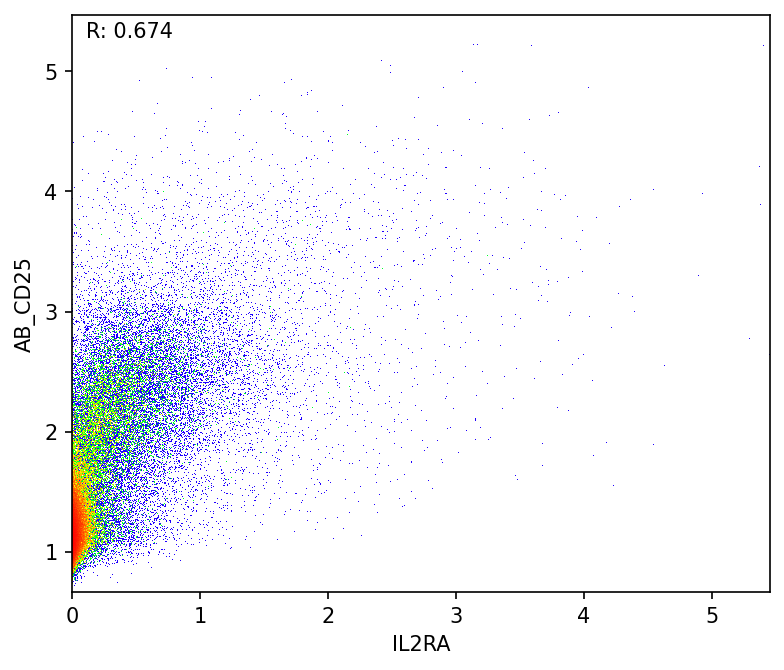

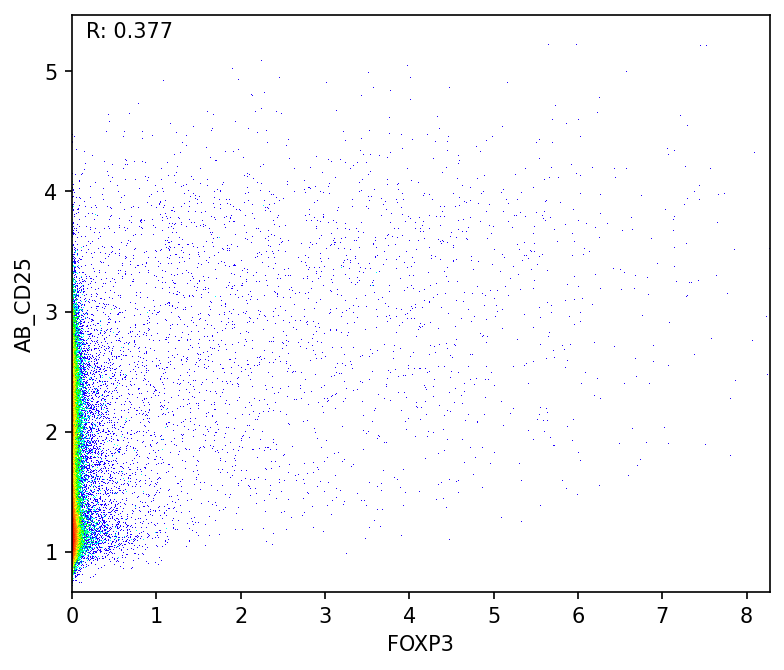

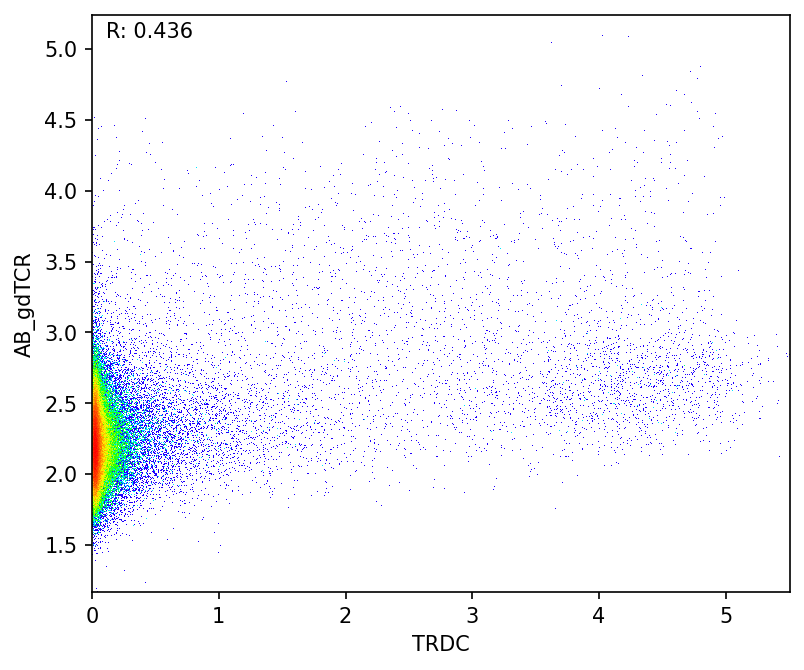

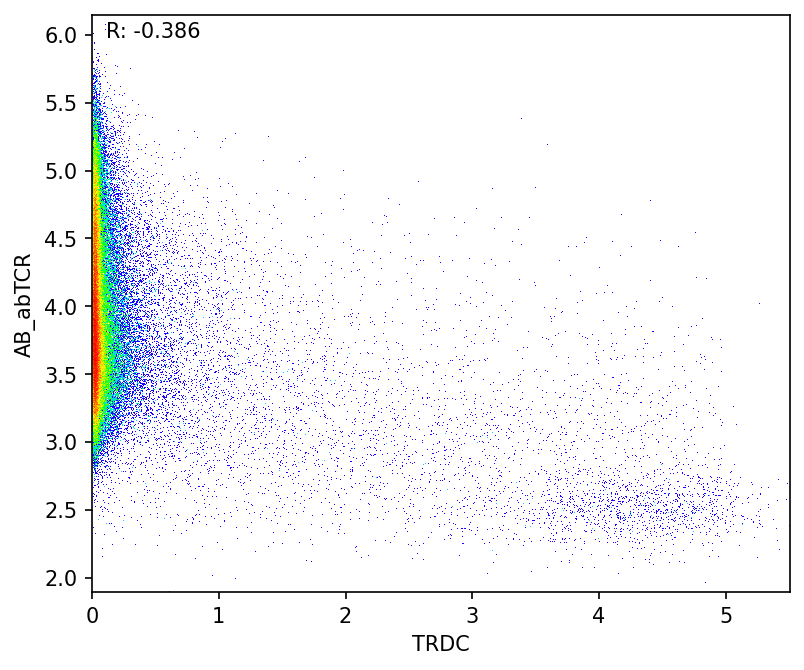

In [46]:
for (gene, prot) in prot_pairs:
    # print(gene, prot)
    r, _ = pearsonr(markers_magic[gene], markers_magic[prot])
    # print(r)
    
    fig, ax = plt.subplots(dpi = 150, figsize=(6,5))
    dsshow(pd.DataFrame({'x':markers_magic[gene], 'y':markers_magic[prot]}), 
           ds.Point('x', 'y'), norm='eq_hist', cmap=cmap, ax = ax, aspect = 'auto')
    # ax.scatter(x = markers_magic[gene], y = markers_magic[prot], s = .2, alpha = .3)
    ax.text(.02, .96, ''.join(['R: ', str(round(r, 3))]), transform=ax.transAxes)
    ax.set_xlabel(gene)
    ax.set_ylabel(prot)

Compare non MAGIC-smoothed markers


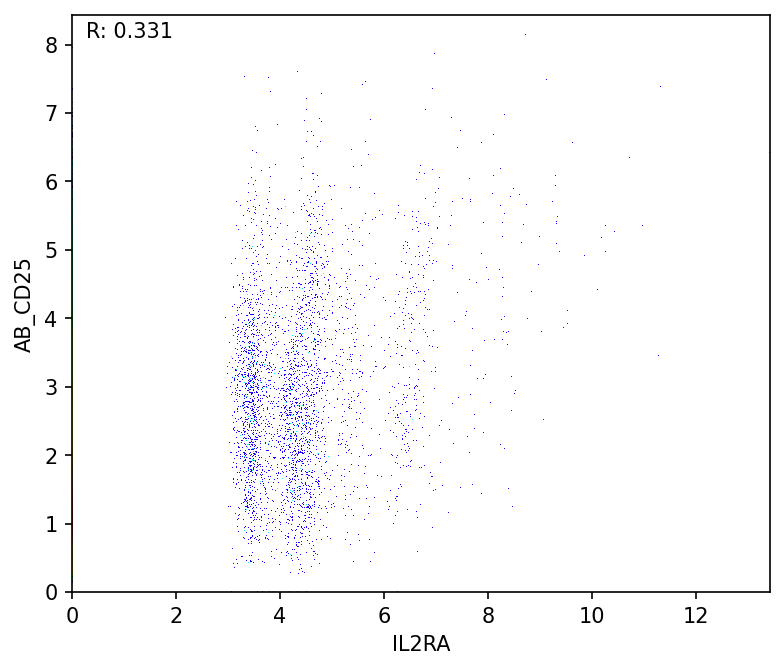

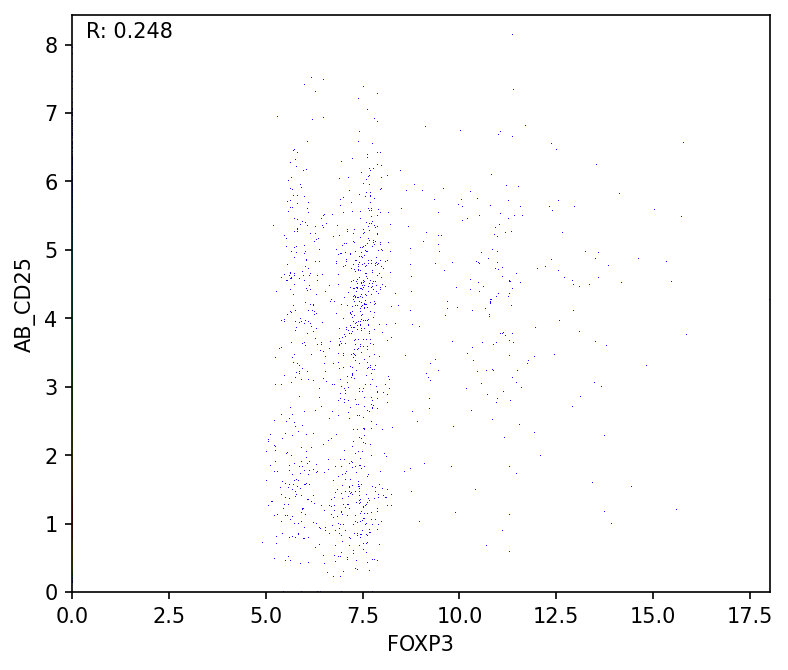

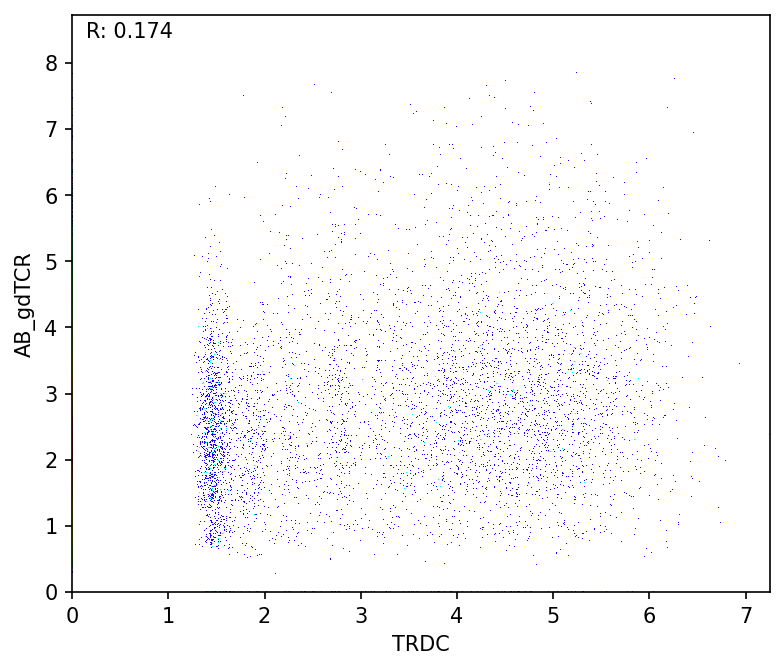

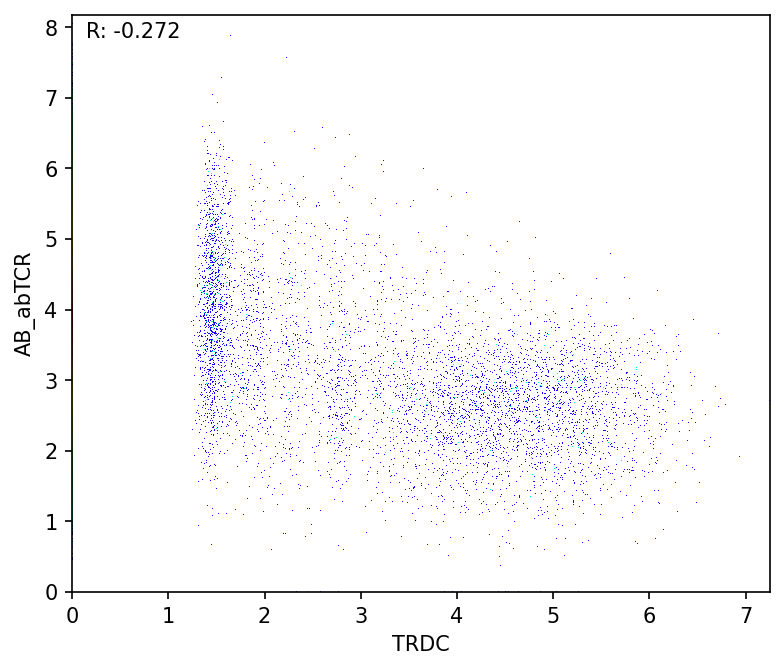

In [47]:
for (gene, prot) in prot_pairs:
    # print(gene, prot)
    r, _ = pearsonr(unsmoothed_markers[gene], unsmoothed_markers[prot])
    # print(r)
    
    fig, ax = plt.subplots(dpi = 150, figsize=(6,5))
    dsshow(pd.DataFrame({'x':unsmoothed_markers[gene], 'y':unsmoothed_markers[prot]}), 
           ds.Point('x', 'y'), norm='eq_hist', cmap=cmap, ax = ax, aspect = 'auto')
    # ax.scatter(x = markers_magic[gene], y = markers_magic[prot], s = .2, alpha = .3)
    ax.text(.02, .96, ''.join(['R: ', str(round(r, 3))]), transform=ax.transAxes)
    ax.set_xlabel(gene)
    ax.set_ylabel(prot)

Compare proteins - MAGIC to non-smoothed

## Lineage marker gating - RNA and proteins

Use both RNA and proteins to gate, including various combinations of CCR7, SELL, CD197, and CD62L.

In [197]:
cmap = plt.cm.hsv
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist = cmaplist[0:round(len(cmaplist)*0.7)]
cmaplist.reverse()
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('', cmaplist, cmap.N)
    
def gate(data, g1, g2, ind=None, vertical_gate=None, horizontal_gate=None, quadrant_gate=None,
         labfontsize=9, plot_labeled=False, upper_only=False):
    
    
    
    fig = plt.figure(constrained_layout=True, figsize=(2., 2.), dpi=200)
    gs = gridspec.GridSpec(1, 1, figure=fig, left=0.2,
                       bottom=.2, right=.95, top=.92)
    ax = fig.add_subplot(gs[0])

    if ind  is None:
        ind = pd.Series(np.array([True]*data.shape[0]), data.index)
    
    
    x = data.loc[ind, g1]
    y = data.loc[ind, g2]
    
    dsshow(pd.DataFrame({'x':x, 'y':y}), ds.Point('x', 'y'), norm='eq_hist', cmap=cmap, ax = ax, aspect = 'auto')
    ax.set_xlabel(g1, fontsize=labfontsize)
    ax.set_ylabel(g2, fontsize=labfontsize)

    
    if vertical_gate is not None:
        xlim = ax.get_xlim()
        ax.hlines(y=vertical_gate['vthresh'], xmin=xlim[0], xmax=xlim[1], linestyle='--', color='k', linewidth=1)
        ax.set_xlim(xlim)
        
            
        initial_res = (data.loc[ind, g2]>vertical_gate['vthresh']).replace({True:vertical_gate['above_name'], False:vertical_gate['below_name']})
        final_res = ind.copy()
        final_res.loc[ind] = initial_res
        final_res.loc[~ind] = np.nan
    elif horizontal_gate is not None:
        ylim = ax.get_ylim()
        ax.vlines(x=horizontal_gate['hthresh'], ymin=ylim[0], ymax=ylim[1], linestyle='--', color='k', linewidth=1)
        ax.set_ylim(ylim)
        
        initial_res = (data.loc[ind, g1]>horizontal_gate['hthresh']).replace({False:horizontal_gate['left_name'], True:horizontal_gate['right_name']})
        final_res = ind.copy()
        final_res.loc[ind] = initial_res
        final_res.loc[~ind] = np.nan
        
        
    elif quadrant_gate is not None:
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        if not upper_only:
            ax.hlines(y=quadrant_gate['vthresh'], xmin=xlim[0]-1, xmax=xlim[1]+1, linestyle='--', color='k', linewidth=1)
            ax.set_xlim(xlim)
            ax.vlines(x=quadrant_gate['hthresh'], ymin=ylim[0]-1, ymax=ylim[1]+1, linestyle='--', color='k', linewidth=1)
            ax.set_ylim(ylim)
        else:
            ax.hlines(y=quadrant_gate['vthresh'], xmin=quadrant_gate['hthresh'], xmax=xlim[1]+1, linestyle='--', color='k', linewidth=1)
            ax.set_xlim(xlim)
            ax.vlines(x=quadrant_gate['hthresh'], ymin=quadrant_gate['vthresh'], ymax=ylim[1]+1, linestyle='--', color='k', linewidth=1)
            ax.set_ylim(ylim)            
            

        indh = data.loc[ind, g1]> quadrant_gate['hthresh']
        indv = data.loc[ind, g2]> quadrant_gate['vthresh']
        final_res = ind.replace(False,np.nan)
        for hval,vval, lab in [[False, False, quadrant_gate['ll']], [True, False, quadrant_gate['lr']], [False, True, quadrant_gate['ul']], [True, True, quadrant_gate['ur']]]:
            tolab = (indh==hval) & (indv==vval)
            final_res.loc[tolab.index[tolab]] = lab
            
            
    if plot_labeled:
        fig = plt.figure(constrained_layout=True, figsize=(2.4, 2.), dpi=200)
        gs = gridspec.GridSpec(1, 1, figure=fig, left=0.2,
                       bottom=.2, right=.8, top=.92)
        ax2 = fig.add_subplot(gs[0])
        dat = pd.concat([x,y,final_res], axis=1)
        dat.columns = [g1, g2, 'label']
        for (k,g) in dat.groupby('label'):
            ax2.scatter(g[g1], g[g2], label=k, s=.5, edgecolor='None')
        ax2.legend(bbox_to_anchor=(1,1), markerscale=3, fontsize=6)
        
        
        
    return(final_res, ax)

In [198]:
gating = pd.DataFrame(index=markers_magic.index, columns=['gdT', 'MAIT', 'CD4_vs_CD8', 'Treg', 'CD4_Naive', 'CD4_Memory_Subset', 'CD8_Conv'])

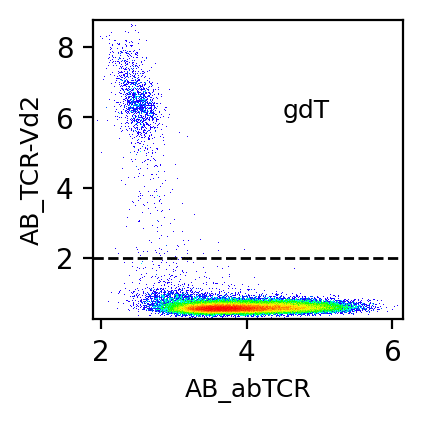

In [199]:
g1 = 'AB_abTCR'
g2 = 'AB_TCR-Vd2'   
vgate = {'vthresh':2, 'above_name':'gdT', 'below_name':'ab'}
gating['gdT'], ax = gate(markers_magic, g1, g2, ind=None, vertical_gate=vgate, plot_labeled=False)

ax.text(4.5,6, 'gdT', fontsize=9)
plt.savefig(os.path.join(figdir, 'ManualGating_HIVVaccine_gdT.png'))
plt.savefig(os.path.join(figdir, 'ManualGating_HIVVaccine_gdT.pdf'))

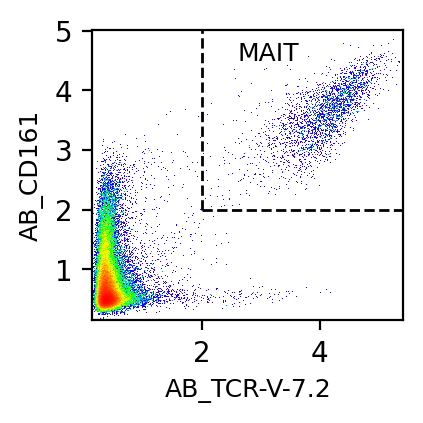

In [200]:
g1 = 'AB_TCR-V-7.2'
g2 = 'AB_CD161'  
gating['MAIT'],ax = gate(markers_magic, g1, g2, ind=gating['gdT']=='ab',
                      quadrant_gate={'vthresh':2, 'hthresh':2, 'ur':'MAIT', 'ul':'ab', 'll':'ab', 'lr':'ab'}, plot_labeled=False, upper_only=True)
ax.text(2.6,4.5, 'MAIT', fontsize=9)
plt.savefig(os.path.join(figdir, 'ManualGating_HIVVaccine_MAIT.png'))
plt.savefig(os.path.join(figdir, 'ManualGating_HIVVaccine_MAIT.pdf'))

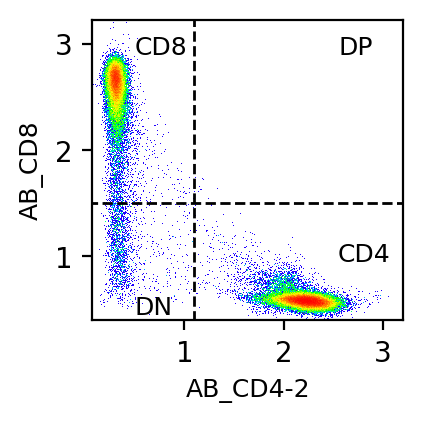

In [201]:
g1 = 'AB_CD4-2'
g2 = 'AB_CD8'    
gating['CD4_vs_CD8'],ax = gate(markers_magic, g1, g2, ind=gating['MAIT']=='ab', quadrant_gate={'vthresh':1.5, 'hthresh':1.1, 'll':'DN', 'ul':'CD8', 'ur':'DP', 'lr':'CD4'})

ax.text(.5, 2.9, 'CD8', fontsize=9)
ax.text(2.55, .95, 'CD4', fontsize=9)
ax.text(2.55,2.9, 'DP', fontsize=9)
ax.text(.5, .45, 'DN', fontsize=9)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlim(xlim[0], xlim[1]+.15)

plt.savefig(os.path.join(figdir, 'ManualGating_HIVVaccine_CD4CD8.png'))
plt.savefig(os.path.join(figdir, 'ManualGating_HIVVaccine_CD4CD8.pdf'))

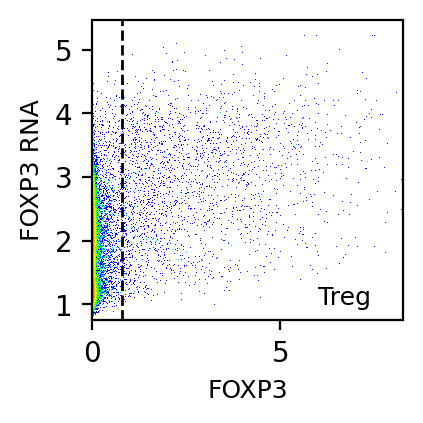

In [203]:
g1 = 'AB_CD25'     
g2 = 'FOXP3'

gating['Treg'],ax = gate(markers_magic, g2, g1, ind=gating['CD4_vs_CD8']=='CD4', horizontal_gate={'hthresh':.8, 'right_name':'Treg', 'left_name':'CD4'},
                      plot_labeled=False)

ax.text(6, 1, 'Treg', fontsize=9)
ax.set_ylabel('FOXP3 RNA', fontsize=9)

plt.savefig(os.path.join(figdir, 'ManualGating_HIVVaccine_Treg.png'))
plt.savefig(os.path.join(figdir, 'ManualGating_HIVVaccine_Treg.pdf'))

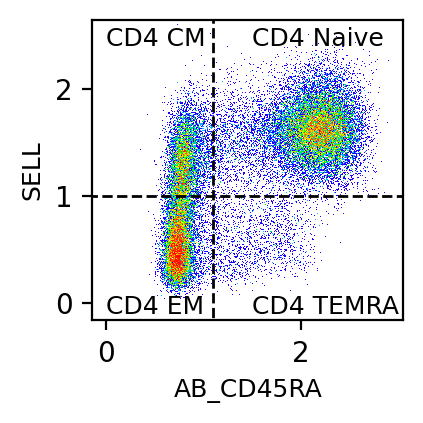

In [204]:
g1 = 'AB_CD45RA'     
g2 = 'SELL'
gating['CD4_Naive'], ax = gate(markers_magic, g1, g2, ind=(gating['Treg']=='CD4'),
                           quadrant_gate={'vthresh':1., 'hthresh':1.1, 'll':'CD4_Memory', 'ur':'CD4_Naive', 'ul':'CD4_Memory', 'lr':'CD4_TEMRA'},
                           plot_labeled=False)

ax.text(1.5, 2.4, 'CD4 Naive', fontsize=9)
ax.text(1.5, -.1, 'CD4 TEMRA', fontsize=9)

ax.text(0, 2.4, 'CD4 CM', fontsize=9)
ax.text(0, -.1, 'CD4 EM', fontsize=9)



xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlim(xlim[0]-.5, xlim[1]+.15)
ax.set_ylim(ylim[0]-.2, ylim[1]+.05)


plt.savefig(os.path.join(figdir, 'ManualGating_HIVVaccine_CD4Naive.png'))
plt.savefig(os.path.join(figdir, 'ManualGating_HIVVaccine_CD4Naive.pdf'))

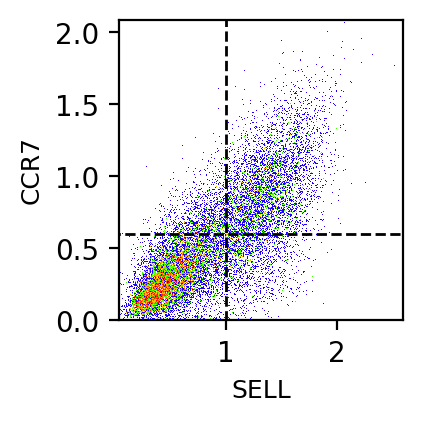

In [205]:
g1 = 'SELL'     
g2 = 'CCR7'
_ = gate(markers_magic, g1, g2, ind=(gating['CD4_Naive']=='CD4_Memory'), quadrant_gate={'vthresh':.6, 'hthresh':1, 'll':'CD4_Memory', 'ul':'CD4_Naive', 'ur':'CD4_Memory', 'lr':'CD4_Memory'})


(L1_AAACCCAAGACATACA      CD4_Memory
 L1_AAACCCACAACTGGTT             NaN
 L1_AAACCCACAGCATACT             NaN
 L1_AAACCCACATCAGTCA             NaN
 L1_AAACCCATCCACACCT             NaN
                             ...    
 E2L8_TTTGGTTTCGTCAACA    CD4_Memory
 E2L8_TTTGTTGAGGCATGCA    CD4_Memory
 E2L8_TTTGTTGAGTAGAGTT    CD4_Memory
 E2L8_TTTGTTGCAGCGTGAA           NaN
 E2L8_TTTGTTGGTCGTGATT           NaN
 Name: CD4_Naive, Length: 73259, dtype: object,
 <AxesSubplot: xlabel='SELL', ylabel='AB_CD27-1'>)

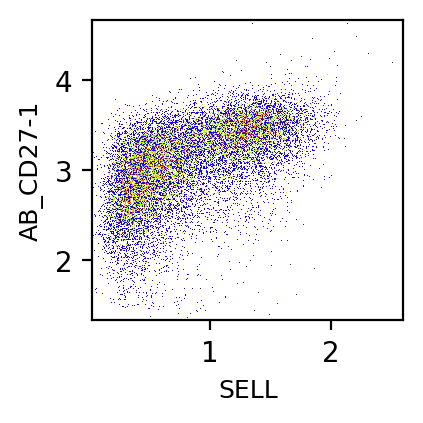

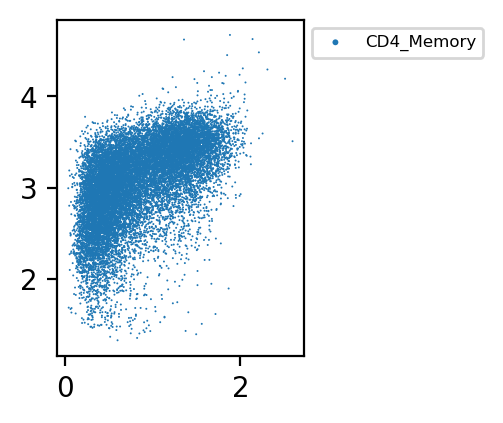

In [206]:
g1 = 'SELL'
g2 = 'AB_CD27-1'     
gate(markers_magic, g1, g2, ind=(gating['CD4_Naive']=='CD4_Memory'),
                                   vertical_gate={'vthresh':.6, 'above_name':'CD4_Memory', 'below_name':'CD4_TerminalEffector'},
                                   plot_labeled=True)


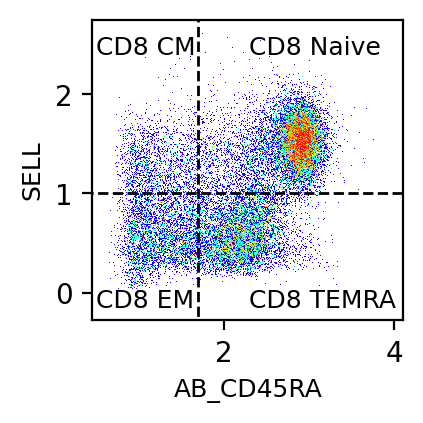

In [207]:
g1 = 'AB_CD45RA'     
g2 = 'SELL'
gating['CD8_Conv'],ax = gate(markers_magic, g1, g2, ind=(gating['CD4_vs_CD8']=='CD8'),
                           quadrant_gate={'vthresh':1, 'hthresh':1.7, 'll':'CD8_EM', 'ul':'CD8_CM', 'ur':'CD8_Naive', 'lr':'CD8_TEMRA'},
                                                             plot_labeled=False)


ax.text(2.3, 2.4, 'CD8 Naive', fontsize=9)
ax.text(2.3, -.15, 'CD8 TEMRA', fontsize=9)

ax.text(0.5, 2.4, 'CD8 CM', fontsize=9)
ax.text(0.5, -.15, 'CD8 EM', fontsize=9)



xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlim(xlim[0]-.2, xlim[1]+.35)
ax.set_ylim(ylim[0]-.3, ylim[1]+.15)


plt.savefig(os.path.join(figdir, 'ManualGating_HIVVaccine_CD8Naive.png'))
plt.savefig(os.path.join(figdir, 'ManualGating_HIVVaccine_CD8Naive.pdf'))

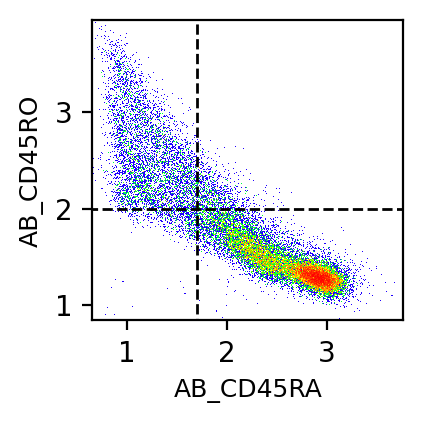

In [208]:
g1 = 'AB_CD45RA'     
g2 = 'AB_CD45RO'
_ = gate(markers_magic, g1, g2, ind=(gating['CD4_vs_CD8']=='CD8'),
                           quadrant_gate={'vthresh':2, 'hthresh':1.7, 'll':'CD8_EM', 'ul':'CD8_CM', 'ur':'CD8_Naive', 'lr':'CD8_TEMRA'},
                                                             plot_labeled=False)

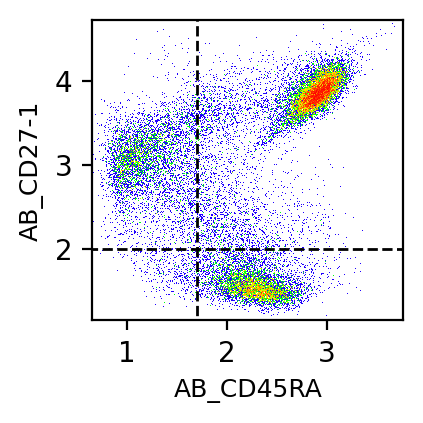

In [209]:
g1 = 'AB_CD45RA'     
g2 = 'AB_CD27-1'     
_ = gate(markers_magic, g1, g2, ind=(gating['CD4_vs_CD8']=='CD8'),
                           quadrant_gate={'vthresh':2, 'hthresh':1.7, 'll':'CD8_EM', 'ul':'CD8_CM', 'ur':'CD8_Naive', 'lr':'CD8_TEMRA'},
                                                             plot_labeled=False)

In [210]:
label = gating.apply(lambda x: x[x.last_valid_index()], axis=1)

In [211]:
label.value_counts()

CD4_Naive     18946
CD4_Memory    17916
CD8_Naive     12667
CD8_TEMRA      7210
CD8_EM         4269
MAIT           2820
Treg           2326
DN             1857
CD8_CM         1849
gdT            1701
CD4_TEMRA      1686
DP               12
dtype: int64

In [212]:
outfn = os.path.join(outdir, 'ManualGating.Magic.20230831.tsv')
print(outfn)

../../../Data/PerDataset/HaoEtAl/ManualGating.Magic.20230831.tsv


In [213]:
gating.to_csv(outfn, sep='\t')

In [214]:
outfn = os.path.join(outdir, 'ManualGating.Magic.FinalLabel.20230831.tsv')
print(outfn)

../../../Data/PerDataset/HaoEtAl/ManualGating.Magic.FinalLabel.20230831.tsv


In [215]:
label.to_csv(outfn, sep='\t')

In [216]:
os.path.abspath('../../../Data/PerDataset/HaoEtAl/ManualGating.Magic.FinalLabel.20230831.tsv')

'/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/ManualGating.Magic.FinalLabel.20230831.tsv'

## Usage overlap

In [217]:
usage_fn = params.loc['HIV-Vaccine', 'usage_fn']
usage = pd.read_csv(usage_fn, sep='\t', index_col=0)
usage = usage.div(usage.sum(axis=1), axis=0)
usage.head()

,CD4_Naive,?MTRNR2L12,CD8_Naive,Translation,?TXNIP/H3F3B,PoorQuality,CD4_CM-1,Effector_Memory,Cytotoxic,Mito,...,?SOX4/MME,Th2,ISG,gdT,dnT/IL10+CD38+,CellCycle_S,CellCycle_Histone,Doublet_Platelet,CellCycle_G2M,Doublet_RBC
L1_AAACCCAAGACATACA,0.071265,0.069201,0.085655,0.091099,0.103862,0.081615,0.210158,0.033020,0.000000,0.021171,...,0.000000,0.013035,0.000000,0.000000,0.000000,0.004477,0.000000,0.000000,0.000498,0.000216
L1_AAACCCACAACTGGTT,0.000000,0.172881,0.332321,0.077529,0.136803,0.064493,0.019394,0.012948,0.011538,0.042815,...,0.000000,0.005074,0.000000,0.000000,0.000000,0.001307,0.000000,0.002853,0.000000,0.000000
L1_AAACCCACAGCATACT,0.050215,0.181361,0.244065,0.100222,0.121348,0.027988,0.000000,0.000000,0.000000,0.035723,...,0.086737,0.000000,0.010209,0.000000,0.000000,0.000000,0.019444,0.000000,0.000000,0.000146
L1_AAACCCACATCAGTCA,0.000000,0.000000,0.000000,0.000000,0.088597,0.083812,0.102824,0.026439,0.003956,0.031803,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001627,0.000000,0.004691,0.000302
L1_AAACCCATCCACACCT,0.060203,0.024476,0.253791,0.058192,0.193729,0.082726,0.002495,0.000000,0.000000,0.034214,...,0.000000,0.000000,0.013982,0.004221,0.035798,0.011412,0.000000,0.000000,0.003477,0.000000


In [218]:
tcat_fn = params.loc['HIV-Vaccine', 'tcat_fn']
tcat_fn

'/data/srlab1/TCAT/Data/TCAT/TCAT_Usage_20230704.HIV-Vaccine.tsv'

In [219]:
tcat_usage = pd.read_csv(tcat_fn, sep='\t', index_col=0)
tcat_usage = tcat_usage.div(tcat_usage.sum(axis=1), axis=0)
tcat_usage.head()

,CellCycle-G2M_CellCycle_G2M,ISG,gdT,Metallothionein,CellCycle-Sphase_CellCycle_S_DTL/FAM111B,Doublet_RBC,CellCycle-Histone_CellCycle-Histone2_CellCycle_Histone,HeatShock,Mito,?ANXA1/MYADM_?CCR10/LMNA_?IL32/S100A_CD4_Memory_LGALS1/S100A10,...,Pan-Cancer:CTSH/FURIN_Single,Pan-Cancer:Treg/TNFRSF18_Single,TBRU:ICOS/CCR4_Single,HIV-Vaccine:?KLRC2/GNLY_Single,HIV-Vaccine:?NK-Like_Single,HIV-Vaccine:Doublet_Plasmablast_Single,Pan-Tissue:?METRNL/CREM/LDLRAD4_Single,Pan-Tissue:CD244+CD8_Single,Pan-Tissue:?CH25H/DDIT4/SOCS3_Single,Pan-Tissue:NK-like_Single
L1_AAACCCAAGACATACA,0.000799,0.001512,0.004217,0.004835,0.000974,0.005012,0.000775,0.004506,0.065513,0.009735,...,0.001464,0.001690,0.045489,0.003323,0.000572,0.005893,0.001493,0.001023,0.022861,0.000387
L1_AAACCCACAACTGGTT,0.000367,0.001878,0.004045,0.007007,0.000734,0.000772,0.000322,0.002200,0.091354,0.005875,...,0.000871,0.000822,0.031251,0.002746,0.000573,0.005356,0.003580,0.001215,0.003755,0.000306
L1_AAACCCACAGCATACT,0.000561,0.004589,0.005272,0.005005,0.002180,0.005041,0.007575,0.006307,0.084898,0.008508,...,0.000858,0.001238,0.026487,0.003134,0.000368,0.004127,0.002389,0.011176,0.002983,0.000659
L1_AAACCCACATCAGTCA,0.001337,0.001462,0.010785,0.006678,0.000593,0.002894,0.000523,0.009324,0.080483,0.007836,...,0.000945,0.002161,0.024113,0.004573,0.002319,0.006300,0.007437,0.002557,0.011026,0.001510
L1_AAACCCATCCACACCT,0.000856,0.006803,0.005371,0.002387,0.000790,0.000587,0.002075,0.000531,0.094899,0.007076,...,0.000588,0.001283,0.036458,0.001761,0.000244,0.003501,0.001880,0.001736,0.005865,0.001264


In [221]:
tcat_gep_info = read_dataset_log('GEP_Name')
tcat_gep_info.head()

,MetaGep_Name,Long_Name,Short_Name,Needs Review,Class,Num_Datasets
0,CellCycle-G2M_CellCycle_G2M,Cell Cycle G2M Phase,CellCycle-G2M,NaN,Known Activity,7.0
1,ISG,Interferon Stimulated Genes,ISG,NaN,Known Activity,7.0
2,gdT,Gamma Delta T Blood,gdT-Blood,NaN,Known Lineage,4.0
3,Metallothionein,Metallothionein,Metallothionein,NaN,Known Activity,5.0
4,CellCycle-Sphase_CellCycle_S_DTL/FAM111B,Cell Cycle S Phase,CellCycle-S,NaN,Known Activity,7.0


In [222]:
rename_map = dict(zip(tcat_gep_info['MetaGep_Name'], tcat_gep_info['Short_Name']))

In [223]:
tcat_usage_ren = tcat_usage.rename(rename_map, axis=1)

Text(0.5, 1.0, 'GEP Enrichment - HIV-Vaccine')

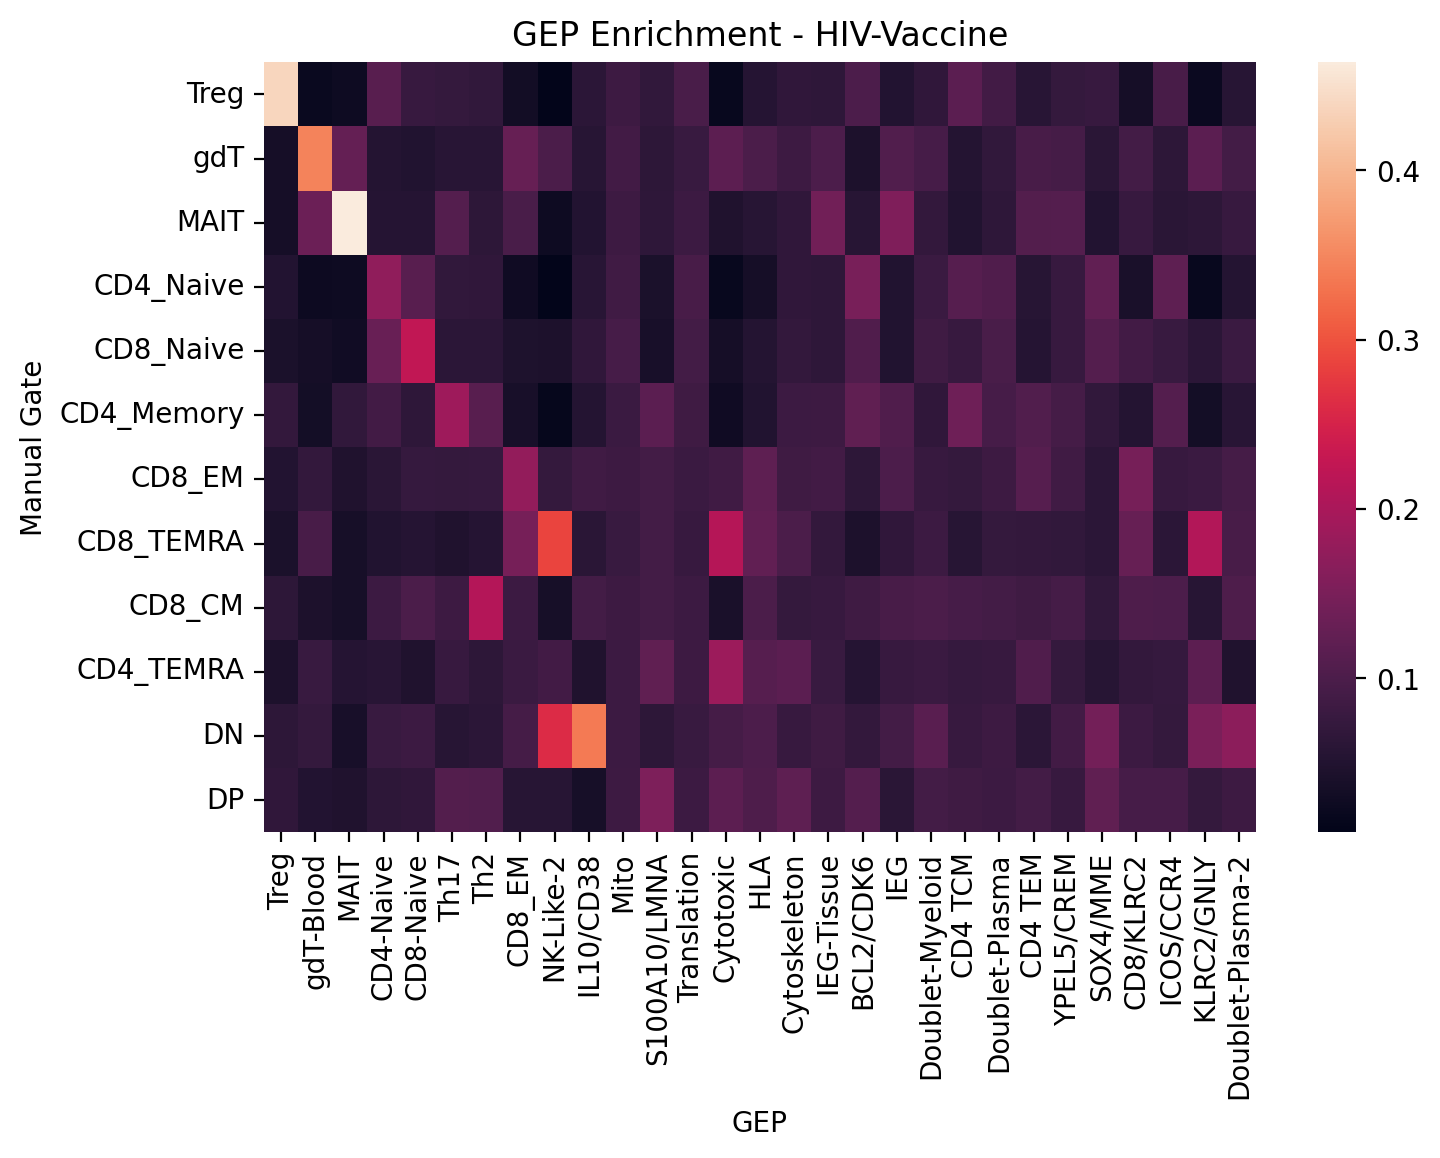

In [231]:
(fig,ax) = plt.subplots(1,1, figsize=(8,5), dpi=200)
cluster = tcat_usage_ren.groupby(label).mean()

lineage_order = ['Treg', 'gdT', 'MAIT','CD4_Naive',  'CD8_Naive', 'CD4_Memory', 'CD8_EM', 'CD8_TEMRA', 'CD8_CM',
                 'CD4_TEMRA', 'DN', 'DP',  ]

gep_order = ['Treg', 'gdT-Blood', 'MAIT', 'CD4-Naive', 'CD8-Naive', 'Th17', 'Th2', 'CD8_EM',  'NK-Like-2', 'IL10/CD38']
gep_order = gep_order + [x for x in cluster.columns if x not in gep_order]


cluster = cluster.loc[lineage_order, gep_order]

max_usage = cluster.max(axis=0).sort_values(ascending=False)
tofilt = max_usage.index[max_usage<0.01]

cluster = cluster.drop(tofilt, axis=1)

cluster = cluster.div(cluster.sum(axis=0), axis=1)


sns.heatmap(cluster, ax=ax, xticklabels=True)
ax.set_ylabel('Manual Gate')
ax.set_xlabel('GEP')
ax.set_title('GEP Enrichment - HIV-Vaccine')